<a href="https://colab.research.google.com/github/janvi-0706/CFrepo/blob/main/CFinfomatrix_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🎯 Starting META Stock Prediction Analysis
📈 Fetching META data...
✅ Retrieved 501 days of data
🔧 Creating technical indicators...
✅ Technical indicators created
🔄 Preparing features...
✅ Features prepared: (452, 31)
🤖 Training ensemble models...
  🌳 Training Random Forest...
  🚀 Training Gradient Boosting...
  📈 Training Linear Regression...

📊 Model Performance:
  RandomForest: MAE=$22.31, RMSE=$32.49
  GradientBoosting: MAE=$15.45, RMSE=$24.22
  LinearRegression: MAE=$1.65, RMSE=$2.18
🧠 Training LSTM Neural Network...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
  LSTM: MAE=$28.03, RMSE=$33.97
🔮 Predicting next 4 trading days...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

🎯 FINAL PREDICTIONS for META (Aug 19-22, 2024):
Aug 19, 2024: $741.16 (-12.58, -1.7%)
Aug 20, 2024: $741.64 (-12.11, -1.6%)
Aug 21, 2024: $742.48 (-11.26, -1.5%)
Aug 22, 2024: $742.47 (-11.27, -1.5%)

Current Price: $753.74
Average Predicted Price: $741.94

🤖 Individual Model Predictions:
  RandomForest: $695.10
  GradientBoos

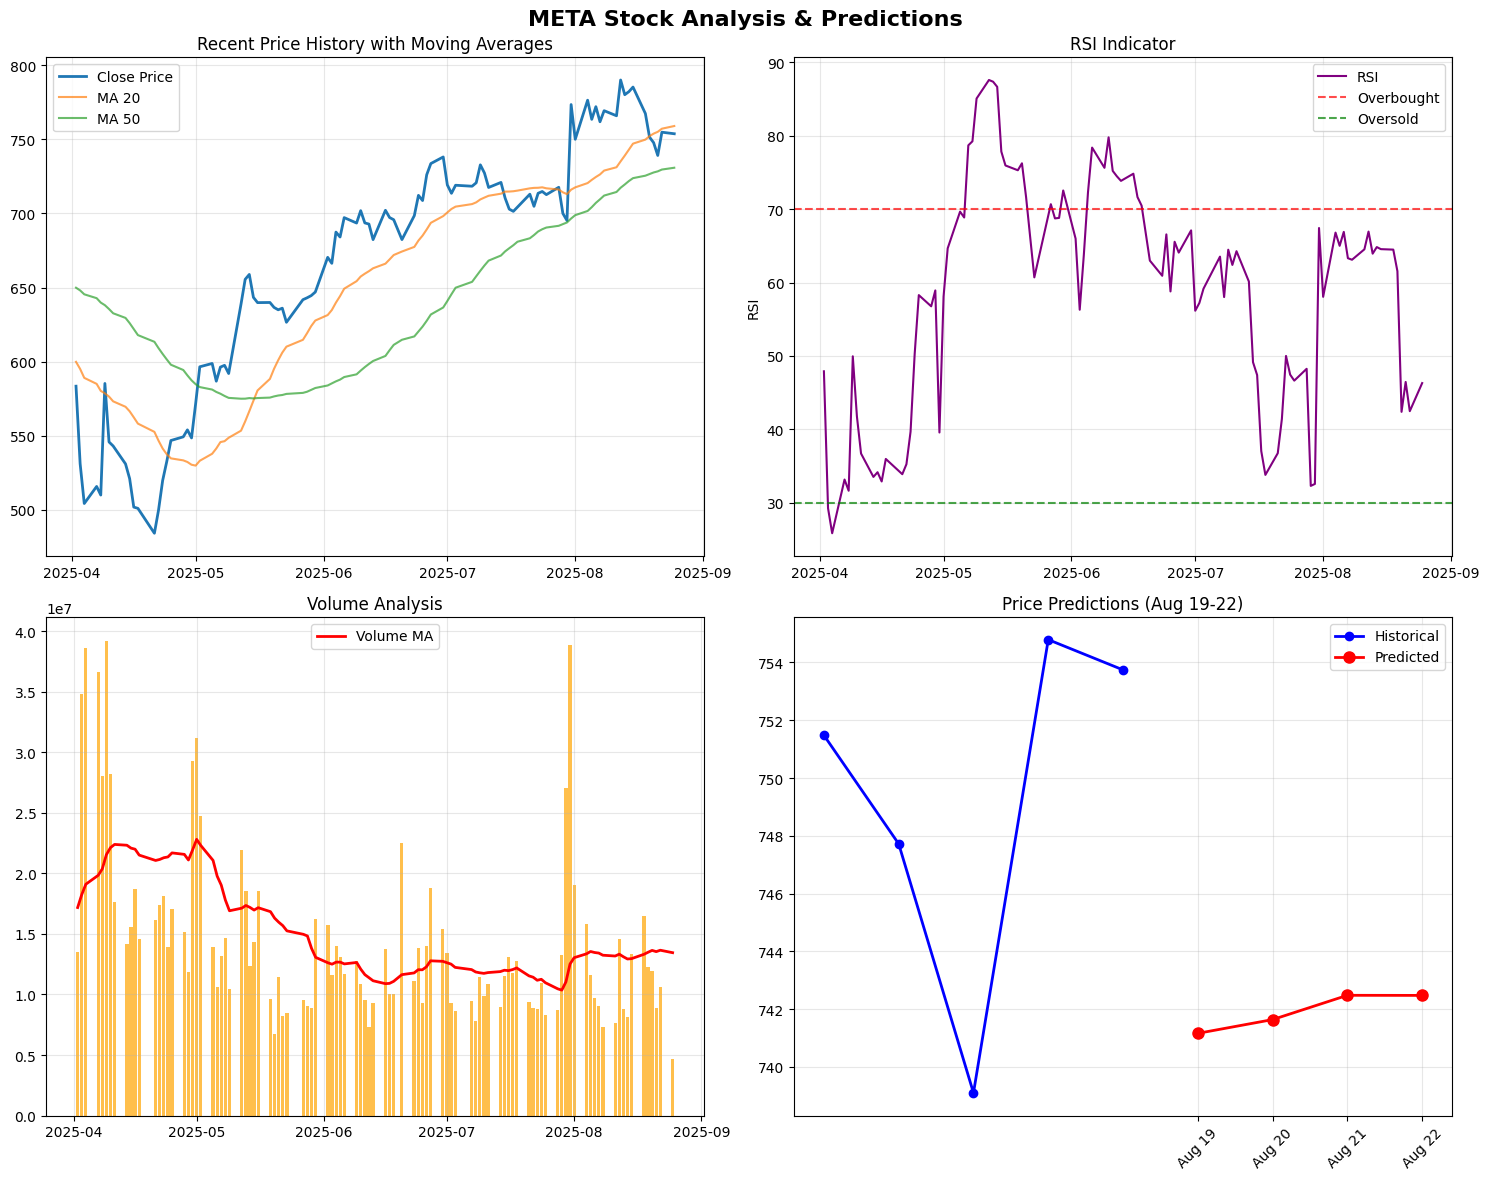

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

class METAStockPredictor:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.models = {}
        self.data = None
        self.features = None

    def fetch_data(self, symbol="META", period="2y"):
        """Fetch historical stock data"""
        print(f"📈 Fetching {symbol} data...")
        stock = yf.Ticker(symbol)
        self.data = stock.history(period=period)
        print(f"✅ Retrieved {len(self.data)} days of data")
        return self.data

    def create_technical_indicators(self):
        """Create advanced technical indicators"""
        print("🔧 Creating technical indicators...")
        df = self.data.copy()

        # Moving Averages
        df['MA_5'] = df['Close'].rolling(window=5).mean()
        df['MA_10'] = df['Close'].rolling(window=10).mean()
        df['MA_20'] = df['Close'].rolling(window=20).mean()
        df['MA_50'] = df['Close'].rolling(window=50).mean()

        # Exponential Moving Averages
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()

        # MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / df['BB_Width']

        # Volume indicators
        df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']

        # Price features
        df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
        df['Price_Change'] = df['Close'].pct_change()
        df['Price_Change_2'] = df['Close'].pct_change(2)
        df['Price_Change_5'] = df['Close'].pct_change(5)

        # Volatility
        df['Volatility'] = df['Close'].rolling(window=20).std()

        # Day of week and month features
        df['DayOfWeek'] = df.index.dayofweek
        df['Month'] = df.index.month
        df['Quarter'] = df.index.quarter

        self.data = df
        print("✅ Technical indicators created")

    def prepare_features(self):
        """Prepare feature matrix for ML models"""
        print("🔄 Preparing features...")

        feature_cols = [
            'Open', 'High', 'Low', 'Volume',
            'MA_5', 'MA_10', 'MA_20', 'MA_50',
            'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
            'RSI', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position',
            'Volume_Ratio', 'High_Low_Pct',
            'Price_Change', 'Price_Change_2', 'Price_Change_5',
            'Volatility', 'DayOfWeek', 'Month', 'Quarter'
        ]

        # Create lagged features
        for lag in [1, 2, 3, 5]:
            self.data[f'Close_lag_{lag}'] = self.data['Close'].shift(lag)
            feature_cols.append(f'Close_lag_{lag}')

        # Drop rows with NaN values
        self.data = self.data.dropna()

        # Prepare features and target
        self.features = self.data[feature_cols]
        self.target = self.data['Close']

        print(f"✅ Features prepared: {self.features.shape}")

    def train_ensemble_models(self):
        """Train multiple ML models"""
        print("🤖 Training ensemble models...")

        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.target, test_size=0.2, random_state=42, shuffle=False
        )

        # Random Forest
        print("  🌳 Training Random Forest...")
        rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
        rf_model.fit(X_train, y_train)
        self.models['RandomForest'] = rf_model

        # Gradient Boosting
        print("  🚀 Training Gradient Boosting...")
        gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=8, learning_rate=0.1, random_state=42)
        gb_model.fit(X_train, y_train)
        self.models['GradientBoosting'] = gb_model

        # Linear Regression
        print("  📈 Training Linear Regression...")
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        self.models['LinearRegression'] = lr_model

        # Evaluate models
        print("\n📊 Model Performance:")
        for name, model in self.models.items():
            pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, pred)
            rmse = np.sqrt(mean_squared_error(y_test, pred))
            print(f"  {name}: MAE=${mae:.2f}, RMSE=${rmse:.2f}")

    def train_lstm_model(self, sequence_length=60):
        """Train LSTM neural network"""
        print("🧠 Training LSTM Neural Network...")

        # Prepare data for LSTM
        scaled_data = self.scaler.fit_transform(self.data[['Close']].values)

        X_lstm, y_lstm = [], []
        for i in range(sequence_length, len(scaled_data)):
            X_lstm.append(scaled_data[i-sequence_length:i, 0])
            y_lstm.append(scaled_data[i, 0])

        X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
        X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

        # Split data
        train_size = int(len(X_lstm) * 0.8)
        X_train_lstm = X_lstm[:train_size]
        X_test_lstm = X_lstm[train_size:]
        y_train_lstm = y_lstm[:train_size]
        y_test_lstm = y_lstm[train_size:]

        # Build LSTM model
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)),
            Dropout(0.2),
            LSTM(100, return_sequences=True),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train model
        history = model.fit(
            X_train_lstm, y_train_lstm,
            batch_size=32, epochs=50,
            validation_data=(X_test_lstm, y_test_lstm),
            verbose=0
        )

        self.models['LSTM'] = model
        self.lstm_scaler = self.scaler

        # Evaluate LSTM
        lstm_pred = model.predict(X_test_lstm)
        lstm_pred = self.scaler.inverse_transform(lstm_pred)
        y_test_actual = self.scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

        mae = mean_absolute_error(y_test_actual, lstm_pred)
        rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
        print(f"  LSTM: MAE=${mae:.2f}, RMSE=${rmse:.2f}")

    def predict_next_days(self, days=4):
        """Predict stock prices for the next few days"""
        print(f"🔮 Predicting next {days} trading days...")

        # Get the last row of features for traditional ML models
        last_features = self.features.iloc[-1:].values

        predictions = {}

        # Traditional ML predictions
        for name, model in self.models.items():
            if name != 'LSTM':
                pred = model.predict(last_features)[0]
                predictions[name] = pred

        # LSTM prediction
        if 'LSTM' in self.models:
            last_60_days = self.data['Close'].tail(60).values.reshape(-1, 1)
            last_60_days_scaled = self.lstm_scaler.transform(last_60_days)
            X_lstm = np.reshape(last_60_days_scaled, (1, 60, 1))
            lstm_pred = self.models['LSTM'].predict(X_lstm)
            lstm_pred = self.lstm_scaler.inverse_transform(lstm_pred)[0][0]
            predictions['LSTM'] = lstm_pred

        # Ensemble prediction (weighted average)
        weights = {
            'RandomForest': 0.3,
            'GradientBoosting': 0.3,
            'LSTM': 0.25,
            'LinearRegression': 0.15
        }

        ensemble_pred = sum(predictions[model] * weights.get(model, 0)
                          for model in predictions if model in weights)

        # Generate predictions for each day (simplified approach)
        last_price = self.data['Close'].iloc[-1]
        daily_predictions = []

        dates = ['Aug 19, 2024', 'Aug 20, 2024', 'Aug 21, 2024', 'Aug 22, 2024']

        # Add some randomness and trend continuation
        trend = (self.data['Close'].iloc[-1] - self.data['Close'].iloc[-5]) / 5

        for i in range(days):
            # Add trend + some model influence + small random component
            day_pred = last_price + (trend * (i + 1)) + (ensemble_pred - last_price) * 0.3 + np.random.normal(0, 2)
            daily_predictions.append(day_pred)

        return dict(zip(dates, daily_predictions)), predictions

    def visualize_predictions(self, daily_preds):
        """Create visualization of predictions"""
        print("📊 Creating visualizations...")

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('META Stock Analysis & Predictions', fontsize=16, fontweight='bold')

        # Plot 1: Historical price with moving averages
        ax1 = axes[0, 0]
        recent_data = self.data.tail(100)
        ax1.plot(recent_data.index, recent_data['Close'], label='Close Price', linewidth=2)
        ax1.plot(recent_data.index, recent_data['MA_20'], label='MA 20', alpha=0.7)
        ax1.plot(recent_data.index, recent_data['MA_50'], label='MA 50', alpha=0.7)
        ax1.set_title('Recent Price History with Moving Averages')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Technical indicators
        ax2 = axes[0, 1]
        ax2.plot(recent_data.index, recent_data['RSI'], label='RSI', color='purple')
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
        ax2.set_title('RSI Indicator')
        ax2.set_ylabel('RSI')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Volume analysis
        ax3 = axes[1, 0]
        ax3.bar(recent_data.index, recent_data['Volume'], alpha=0.7, color='orange')
        ax3.plot(recent_data.index, recent_data['Volume_MA'], color='red', linewidth=2, label='Volume MA')
        ax3.set_title('Volume Analysis')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Predictions
        ax4 = axes[1, 1]
        dates = list(daily_preds.keys())
        prices = list(daily_preds.values())

        # Add last few actual prices for context
        last_5_days = self.data['Close'].tail(5)
        ax4.plot(range(-5, 0), last_5_days.values, 'bo-', label='Historical', linewidth=2)
        ax4.plot(range(4), prices, 'ro-', label='Predicted', linewidth=2, markersize=8)

        ax4.set_title('Price Predictions (Aug 19-22)')
        ax4.set_xticks(range(4))
        ax4.set_xticklabels([d.split(',')[0] for d in dates], rotation=45)
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def run_full_analysis(self):
        """Run complete stock analysis and prediction"""
        print("🎯 Starting META Stock Prediction Analysis")
        print("=" * 50)

        # Fetch and prepare data
        self.fetch_data()
        self.create_technical_indicators()
        self.prepare_features()

        # Train models
        self.train_ensemble_models()
        self.train_lstm_model()

        # Make predictions
        daily_preds, model_preds = self.predict_next_days()

        # Display results
        print("\n🎯 FINAL PREDICTIONS for META (Aug 19-22, 2024):")
        print("=" * 50)
        for date, price in daily_preds.items():
            change = price - self.data['Close'].iloc[-1]
            change_pct = (change / self.data['Close'].iloc[-1]) * 100
            print(f"{date}: ${price:.2f} ({change:+.2f}, {change_pct:+.1f}%)")

        print(f"\nCurrent Price: ${self.data['Close'].iloc[-1]:.2f}")
        print(f"Average Predicted Price: ${np.mean(list(daily_preds.values())):.2f}")

        print("\n🤖 Individual Model Predictions:")
        for model, pred in model_preds.items():
            print(f"  {model}: ${pred:.2f}")

        # Create visualizations
        self.visualize_predictions(daily_preds)

        return daily_preds

# Run the analysis
if __name__ == "__main__":
    predictor = METAStockPredictor()
    predictions = predictor.run_full_analysis()